In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit
import warnings
from stats_helpers import mean_ci, cohen_d,row_format, bland_altman_plot
from scipy.stats import mannwhitneyu
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('data/data.xlsx')
df['groups_idx'] = df['group']
df['updrs_diff'] = df['w24_updrsiii'] - df['w0_updrsiii']
df['seheps_diff'] = df['w8_seheps'] - df['seheps']
df['w8-w0_mep'] = df['w8_mep'] - df['w0_mep']
df['w24-w8_mep'] = df['w24_mep'] - df['w8_mep']
df['w24-w0_mep'] = df['w24_mep'] - df['w0_mep']
df['w8-24_adh'] = df['w8-24_total'] > (0.7 * 800)
df['W1_mep_diff'] = df['w0_mep'] - df['w1_mep']

# Adjust group indices
df.loc[df['group'] == 0, 'groups_idx'] = 1
df.loc[df['group'] == 1, 'groups_idx'] = 2
df['groups_idx_seheps'] = df['groups_idx']
df.loc[(df['group'] == 0) & (df['w8_seheps'] >= 59), 'groups_idx_seheps'] = 3
df.loc[(df['group'] == 1) & (df['w8_seheps'] >= 59), 'groups_idx_seheps'] = 4
display(df)

,ID,group,gender,moca,age,duration,dopamin_therapy,led_mg,advanced_therapies,education_years,...,w24_mep,groups_idx,updrs_diff,seheps_diff,w8-w0_mep,w24-w8_mep,w24-w0_mep,w8-24_adh,W1_mep_diff,groups_idx_seheps
0,CG_1,0,M,29,67,5,1,450.0,0,18,...,NaN,1,NaN,NaN,NaN,NaN,NaN,False,7.0,1
1,CG_2,0,F,27,69,19,1,938.0,0,13,...,157.0,1,0.0,38.0,20.0,41.0,61.0,True,25.0,3
2,CG_3,0,F,25,60,24,1,1000.0,0,15,...,NaN,1,NaN,NaN,NaN,NaN,NaN,False,9.0,1
3,CG_4,0,M,25,58,9,1,450.0,0,18,...,NaN,1,NaN,NaN,NaN,NaN,NaN,False,12.0,1
4,CG_5,0,M,29,64,3,1,300.0,0,17,...,182.0,1,-1.0,5.0,49.0,0.0,49.0,True,17.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,EG_33,1,M,26,77,2,1,600.0,0,22,...,160.0,2,-1.0,34.0,29.0,-16.0,13.0,True,-9.0,4
71,EG_34,1,M,28,50,7,1,875.0,0,22,...,214.0,2,-12.0,28.0,76.0,-5.0,71.0,False,-5.0,2
72,EG_35,1,F,26,63,7,1,750.0,0,18,...,70.0,2,5.0,25.0,1.0,9.0,10.0,True,4.0,4
73,EG_36,1,M,25,62,6,1,600.0,0,16,...,144.0,2,1.0,26.0,57.0,3.0,60.0,True,14.0,4


## Splitting into groups and basic data description
Splitting the data into control (CG) and experimental (EG) groups, naming the groups, and basic variable description.

In [2]:
# Split into groups and basic description
CG = df[df['group'] == 0].copy()  # Control group
EG = df[df['group'] == 1].copy()  # Experimental group
group_names = ['CG', 'EG']
group_names_seheps = ['CG SEHEPS <59', 'EG SEHEPS <59', 'CG SEHEPS >= 59', 'EG SEHEPS >= 59']

# Basic description of selected variables
params = ['moca','age','duration','education_years','height','weight','bmi','led_mg','w0_updrsiii','seheps','w0_mep','w0_vpcf']
display(df[params].describe().applymap(lambda x: round(x, 3)))

,moca,age,duration,education_years,height,weight,bmi,led_mg,w0_updrsiii,seheps,w0_mep,w0_vpcf
count,75.000,75.000,75.000,75.000,75.000,75.000,75.000,62.000,75.000,75.000,75.000,75.000
mean,26.107,65.453,7.147,15.253,173.253,79.053,26.121,683.194,17.267,40.240,133.413,458.493
std,2.934,9.154,5.208,2.886,9.023,18.778,4.662,295.486,9.095,16.261,46.384,131.150
min,19.000,43.000,1.000,9.000,158.000,48.000,17.647,150.000,2.000,9.000,47.000,113.000
25%,24.000,59.000,4.000,13.000,166.000,67.500,22.903,450.000,11.000,28.500,95.500,366.500
50%,26.000,67.000,6.000,15.000,172.000,76.000,25.469,600.000,16.000,39.000,133.000,445.000
75%,29.000,71.500,8.000,18.000,179.500,90.000,29.013,1000.000,21.000,53.000,165.000,534.500
max,30.000,80.000,29.000,22.000,195.000,140.000,36.818,1300.000,48.000,72.000,260.000,745.000


## Comparison of groups in demographic and clinical parameters at baseline
Comparison of control and experimental groups using t-test for selected parameters.

In [13]:
from scipy.stats import fisher_exact

# Baseline demographic characteristics table

# Define mapping for display names and units
baseline_params = [
    ('gender', 'Sex (Male/Female)'),
    ('age', 'Age (y)'),
    ('height', 'Height (m)'),
    ('weight', 'Weight (kg)'),
    ('bmi', 'BMI'),
    ('education_years', 'Education (y)'),
    ('duration', 'Disease duration (y)'),
    ('w0_hy', 'Hoehn & Yahr'),
    ('w0_updrsiii', 'MDS-UPDRS III, ON'),
    ('moca', 'MoCa'),
    ('led_mg', 'LEDD (mg/day)'),
    ('seheps', 'SEHEPS'),
    ('w0_mep', 'Maximum expiratory pressure (cmH2O)')
]

rows = []
for col, label in baseline_params:
    if col == 'gender':
        # Count males and females
        cg_m = (CG['gender'] == 'M').sum()
        cg_f = (CG['gender'] == 'F').sum()
        eg_m = (EG['gender'] == 'M').sum()
        eg_f = (EG['gender'] == 'F').sum()
        row_format = [label, f"{cg_m}/{cg_f}", f"{eg_m}/{eg_f}", '']
        # Fisher's exact test for gender distribution
        table = np.array([[cg_m, cg_f], [eg_m, eg_f]])
        _, p_val_gender = fisher_exact(table)
        row_format[3] = f"{p_val_gender:.3f}"
    else:
        cg_vals = CG[col].dropna()
        eg_vals = EG[col].dropna()
        cg_mean = cg_vals.mean()
        cg_std = cg_vals.std()
        eg_mean = eg_vals.mean()
        eg_std = eg_vals.std()
        # t-test
        # Test for normality using Kolmogorov–Smirnov
        cg_norm = stats.kstest((cg_vals - cg_vals.mean()) / cg_vals.std(ddof=0), 'norm').pvalue > 0.05
        eg_norm = stats.kstest((eg_vals - eg_vals.mean()) / eg_vals.std(ddof=0), 'norm').pvalue > 0.05
        if cg_norm and eg_norm:
            t_stat, p_val = stats.ttest_ind(cg_vals, eg_vals, nan_policy='omit')
            normality = '*'
        else:
            stat, p_val = mannwhitneyu(cg_vals, eg_vals, alternative='two-sided')
            normality = ''
            
        
        row_format = [
            label,
            f"{cg_mean:.1f} ({cg_std:.1f})",
            f"{eg_mean:.1f} ({eg_std:.1f})",
            f"{p_val:.3f}{normality}"
        ]
    rows.append(row_format)

# Create DataFrame for display
baseline_table = pd.DataFrame(
    rows,
    columns=['Measure', 'Control group (n=38)', 'Experimental group (n=37)', 'P-value']
)
display(baseline_table)

,Measure,Control group (n=38),Experimental group (n=37),P-value
0,Sex (Male/Female),21/17,24/13,0.482
1,Age (y),65.4 (9.5),65.5 (8.9),0.995*
2,Height (m),173.7 (8.9),172.8 (9.3),0.678*
3,Weight (kg),78.3 (19.2),79.8 (18.5),0.742*
4,BMI,25.8 (5.0),26.5 (4.4),0.509*
5,Education (y),14.9 (2.9),15.6 (2.9),0.246
6,Disease duration (y),7.0 (5.7),7.3 (4.7),0.580
7,Hoehn & Yahr,2.0 (0.5),2.0 (0.5),0.835
8,"MDS-UPDRS III, ON",17.1 (8.8),17.5 (9.5),0.858*
9,MoCa,26.3 (3.0),25.9 (2.9),0.643*


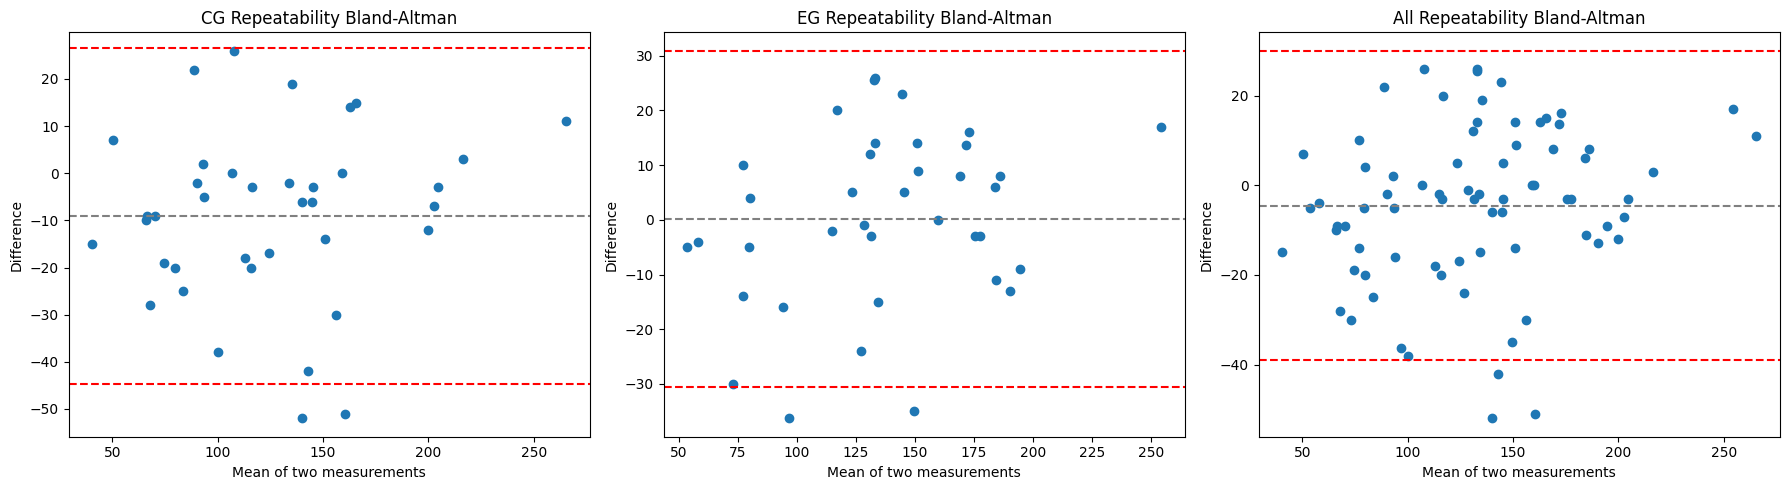

In [4]:
# 2. Reliability of MEP measurement (W-1 and W0)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

bland_altman_plot(CG['w1_mep'], CG['w0_mep'], 'CG Repeatability Bland-Altman', ax=axes[0])
bland_altman_plot(EG['w1_mep'], EG['w0_mep'], 'EG Repeatability Bland-Altman', ax=axes[1])
bland_altman_plot(df['w1_mep'], df['w0_mep'], 'All Repeatability Bland-Altman', ax=axes[2])

plt.tight_layout()
plt.show()

,Interval,CG n,CG Mean (SD),EG n,EG Mean (SD),P-value,Cohen d,Cohen d 95% CI
0,W8-12,28,223.5 (125.7),30,296.2 (167.6),0.084,0.49,-0.03 to 1.01
1,W12-16,28,201.7 (140.8),30,306.4 (202.8),0.028,0.60,0.07 to 1.12
2,W16-20,28,189.5 (158.2),30,275.6 (197.1),0.053,0.48,-0.04 to 1.00
3,W20-24,28,157.3 (151.6),30,260.4 (170.6),0.019,0.64,0.11 to 1.17


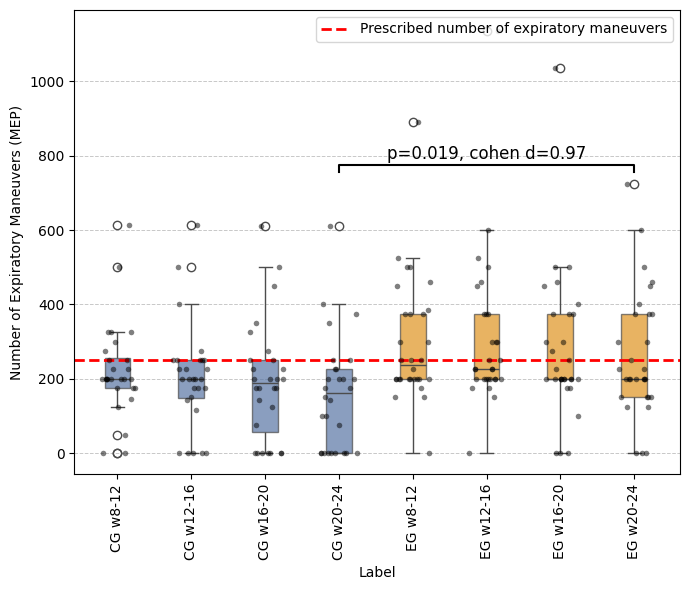

In [14]:
test_table = []
intervals = ['w8-12', 'w12-16', 'w16-20', 'w20-24']
for w in intervals:
    cg_vals = CG[w].dropna()
    eg_vals = EG[w].dropna()
    n_cg = len(cg_vals)
    n_eg = len(eg_vals)
    mean_cg = cg_vals.mean()
    std_cg = cg_vals.std()
    mean_eg = eg_vals.mean()
    std_eg = eg_vals.std()
    # t-test
    stat, p_val = mannwhitneyu(cg_vals, eg_vals, alternative='two-sided')
    
    # Cohen's d
    d, d_ci = cohen_d(cg_vals, eg_vals)
    test_table.append([
        w.replace('w', 'W').replace('_', '-'),
        n_cg, f"{mean_cg:.1f} ({std_cg:.1f})",
        n_eg, f"{mean_eg:.1f} ({std_eg:.1f})",
        f"{p_val:.3f}", f"{d:.2f}", f"{d_ci[0]:.2f} to {d_ci[1]:.2f}"
    ])

ttest_df = pd.DataFrame(
    test_table,
    columns=[
        "Interval",
        "CG n", "CG Mean (SD)",
        "EG n", "EG Mean (SD)",
        "P-value", "Cohen d", "Cohen d 95% CI"
    ]
)
display(ttest_df)



# Prepare data for boxplots using seaborn with jittered points
cg_weeks = ['w8-12', 'w12-16', 'w16-20', 'w20-24']
eg_weeks = ['w8-12', 'w12-16', 'w16-20', 'w20-24']

# Prepare long-form DataFrame for seaborn
plot_data = []
for i, w in enumerate(cg_weeks):
    for val in CG[w].dropna():
        plot_data.append({'Group': 'CG', 'Week': w, 'Value': val})
for i, w in enumerate(eg_weeks):
    for val in EG[w].dropna():
        plot_data.append({'Group': 'EG', 'Week': w, 'Value': val})
plot_df = pd.DataFrame(plot_data)

# Create a combined label for plotting
plot_df['Label'] = plot_df['Group'] + ' ' + plot_df['Week']

# Define custom palette: CG = blue, EG = orange
cg_color = '#4C72B0'  # blue
eg_color = '#FF9900'  # orange
labels = [f'CG {w}' for w in cg_weeks] + [f'EG {w}' for w in eg_weeks]
palette = [cg_color]*4 + [eg_color]*4

plt.figure(figsize=(7, 6))  # Reduce width to bring boxplots closer
ax = sns.boxplot(
    x='Label', y='Value', data=plot_df, order=labels, palette=palette,
    showmeans=False, boxprops=dict(alpha=.7), width=0.35
)
sns.stripplot(
    x='Label', y='Value', data=plot_df, order=labels, color='black',
    size=4, jitter=0.25, alpha=0.5, ax=ax
)


# Red dashed line at y=250
plt.axhline(250, color='red', linestyle='--', linewidth=2, label='Prescribed number of expiratory maneuvers')

# Set x-axis labels vertical
ax.set_xticklabels(labels, rotation=90)

ax.set_ylabel('Number of Expiratory Maneuvers (MEP)')
ax.legend(loc='upper right')

# Draw line and annotate p-value and Cohen's d between CG W20-24 and EG W20-24
x1, x2 = 3, 7  # CG W20-24 and EG W20-24 (0-based index)
y, h = max(plot_df[plot_df['Label'] == 'CG w20-24']['Value'].max(),
           plot_df[plot_df['Label'] == 'EG w20-24']['Value'].max()) + 30, 20
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color='black')
ax.text((x1+x2)/2, y+h+5, "p=0.019, cohen d=0.67", ha='center', va='bottom', fontsize=12)

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()

# Table for t-test and Cohen's d for differences between CG and EG for each week interval




### Overall adherence (All patients)

In [ ]:
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd
from stats_helpers import mean_ci, cohen_d

# Helper for row formatting
def row_format1(group, n, mean, std, ci, pval=None, d=None, dci=None):
    r = [group, n, f"{mean:.0f}", f"{std:.1f}", f"[{ci[0]:.0f}, {ci[1]:.0f}]"]
    if pval is not None:
        r.append(f"{pval:.2f}")
    else:
        r.append("")
    if d is not None:
        r.append(f"{d:.2f}")
        r.append(f"[{dci[0]:.2f}, {dci[1]:.2f}]")
    else:
        r.append("")
        r.append("")
    return r


table_oa = []
columns = ["Time interval", "Group", "n", "Mean", "SD", "95% CI", "P-value", "Cohen d", "Cohen d 95% CI" ]

# W0-8
cg0 = CG['w0-8_total'].dropna()
eg0 = EG['w0-8_total'].dropna()
mean_cg0, std_cg0, n_cg0, ci_cg0 = mean_ci(cg0)
mean_eg0, std_eg0, n_eg0, ci_eg0 = mean_ci(eg0)
stat0, p0 = mannwhitneyu(cg0, eg0, alternative='two-sided')
d0, d0ci = cohen_d(cg0, eg0)
table_oa.append(["W0-8", "CG"] + row_format1("CG", n_cg0, mean_cg0, std_cg0, ci_cg0, p0, d0, d0ci)[1:])
table_oa.append(["", "EG"] + row_format1("EG", n_eg0, mean_eg0, std_eg0, ci_eg0)[1:])

# W8-24
cg1 = CG['w8-24_total'].dropna()
eg1 = EG['w8-24_total'].dropna()
mean_cg1, std_cg1, n_cg1, ci_cg1 = mean_ci(cg1)
mean_eg1, std_eg1, n_eg1, ci_eg1 = mean_ci(eg1)
stat1, p1 = mannwhitneyu(cg1, eg1, alternative='two-sided')
d1, d1ci = cohen_d(cg1, eg1)
table_oa.append(["W8-24", "CG"] + row_format1("CG", n_cg1, mean_cg1, std_cg1, ci_cg1, p1, d1, d1ci)[1:])
table_oa.append(["", "EG"] + row_format1("EG", n_eg1, mean_eg1, std_eg1, ci_eg1)[1:])

adherence_table = pd.DataFrame(table_oa, columns=columns)
display(adherence_table)



,Time interval,Group,n,Mean,SD,95% CI,P-value,Cohen d,Cohen d 95% CI
0,W0-8,CG,32,953,83.2,"[924, 982]",0.05,0.49,"[0.01, 0.98]"
1,,EG,35,998,95.7,"[966, 1029]",,,
2,W8-24,CG,29,771,538.4,"[575, 967]",0.02,0.58,"[0.06, 1.10]"
3,,EG,30,1139,712.0,"[884, 1393]",,,


### Adherence analysis based on SEHEPS at Week 8

In [ ]:

table_sh = []
cg_s1 = CG[CG['w8_seheps'] < 59]['w8-24_total'].dropna()
eg_s1 = EG[EG['w8_seheps'] < 59]['w8-24_total'].dropna()
mean_cg_s1, std_cg_s1, n_cg_s1, ci_cg_s1 = mean_ci(cg_s1)
mean_eg_s1, std_eg_s1, n_eg_s1, ci_eg_s1 = mean_ci(eg_s1)
stat_s1, p_s1 = mannwhitneyu(cg_s1, eg_s1, alternative='two-sided')
d_s1, dci_s1 = cohen_d(cg_s1, eg_s1)
table_sh.append(["W8-24", "CG SEHEPS <59"] + row_format1("CG SEHEPS <59", n_cg_s1, mean_cg_s1, std_cg_s1, ci_cg_s1, p_s1, d_s1, dci_s1)[1:])
table_sh.append(["", "EG SEHEPS <59"] + row_format1("EG SEHEPS <59", n_eg_s1, mean_eg_s1, std_eg_s1, ci_eg_s1)[1:])

# >=59
cg_s2 = CG[CG['w8_seheps'] >= 59]['w8-24_total'].dropna()
eg_s2 = EG[EG['w8_seheps'] >= 59]['w8-24_total'].dropna()
mean_cg_s2, std_cg_s2, n_cg_s2, ci_cg_s2 = mean_ci(cg_s2)
mean_eg_s2, std_eg_s2, n_eg_s2, ci_eg_s2 = mean_ci(eg_s2)
stat_s2, p_s2 = mannwhitneyu(cg_s2, eg_s2, alternative='two-sided')
d_s2, dci_s2 = cohen_d(cg_s2, eg_s2)
table_sh.append(["W8-24", "CG SEHEPS ≥59"] + row_format1("CG SEHEPS ≥59", n_cg_s2, mean_cg_s2, std_cg_s2, ci_cg_s2, p_s2, d_s2, dci_s2)[1:])
table_sh.append(["", "EG SEHEPS ≥59"] + row_format1("EG SEHEPS ≥59", n_eg_s2, mean_eg_s2, std_eg_s2, ci_eg_s2)[1:])

adherence_table = pd.DataFrame(table_sh, columns=columns)
display(adherence_table)

,Time interval,Group,n,Mean,SD,95% CI,P-value,Cohen d,Cohen d 95% CI
0,W8-24,CG SEHEPS <59,17,525,350.8,"[358, 692]",0.04,0.80,"[0.10, 1.50]"
1,,EG SEHEPS <59,17,1073,903.0,"[643, 1502]",,,
2,W8-24,CG SEHEPS ≥59,12,1120,576.6,"[794, 1446]",0.34,0.22,"[-0.57, 1.01]"
3,,EG SEHEPS ≥59,13,1225,351.6,"[1034, 1416]",,,


### Four-Week Interval adherence analysis in patients at risk of non-adherence (SEHEPS <59)

In [ ]:

table_fw = []
at_risk_CG = CG[CG['w8_seheps'] < 59]
at_risk_EG = EG[EG['w8_seheps'] < 59]
intervals = ['w8-12', 'w12-16', 'w16-20', 'w20-24']
for w in intervals:
    cg_w = at_risk_CG[w].dropna()
    eg_w = at_risk_EG[w].dropna()
    mean_cg, std_cg, n_cg, ci_cg = mean_ci(cg_w)
    mean_eg, std_eg, n_eg, ci_eg = mean_ci(eg_w)
    stat, p = mannwhitneyu(cg_w, eg_w, alternative='two-sided')
    d, dci = cohen_d(cg_w, eg_w)
    table_fw.append([w.replace('w', 'W').replace('_', '-'), "CG"] + row_format1("CG", n_cg, mean_cg, std_cg, ci_cg, p, d, dci)[1:])
    table_fw.append(["", "EG"] + row_format1("EG", n_eg, mean_eg, std_eg, ci_eg)[1:])

adherence_table = pd.DataFrame(table_fw, columns=columns)
display(adherence_table)

,Time interval,Group,n,Mean,SD,95% CI,P-value,Cohen d,Cohen d 95% CI
0,W8-12,CG,16,175,91.7,"[130, 220]",0.23,0.64,"[-0.06, 1.34]"
1,,EG,17,277,204.3,"[180, 374]",,,
2,W12-16,CG,16,144,105.1,"[92, 195]",0.07,0.79,"[0.08, 1.50]"
3,,EG,17,301,257.9,"[178, 423]",,,
4,W16-20,CG,16,114,118.0,"[56, 172]",0.09,0.71,"[0.00, 1.41]"
5,,EG,17,255,252.4,"[135, 375]",,,
6,W20-24,CG,16,78,91.2,"[33, 123]",0.01,0.99,"[0.27, 1.72]"
7,,EG,17,240,208.4,"[141, 339]",,,


In [22]:
# Table 3. Overall changes in MEP and Subgroup Analysis Based on SEHEPS at Week 8
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind
from stats_helpers import mean_ci, cohen_d

rows = []
def row_format2(
    interval, group, n, mean_pre, std_pre, mean_post, std_post, mean_diff, std_diff, ci_diff, pval=None, d=None, d_ci=None):
    row = [interval, group, n,
           f"{mean_pre:.1f} ({std_pre:.1f})", f"{mean_post:.1f} ({std_post:.1f})",
           f"{mean_diff:+.1f} ({std_diff:.1f})", f"[{ci_diff[0]:.1f}, {ci_diff[1]:.1f}]"
    ]
    if pval is not None:
        row.append(f"{pval:.3f}")
    else:
        row.append("")
    if d is not None and d_ci is not None:
        row.append(f"{d:.2f} [{d_ci[0]:.2f}, {d_ci[1]:.2f}]")
    else:
        row.append("")
    return row

# Helper to get stats from precomputed columns
def stats_from_diff(pre, post, diff):
    # Only keep entries where diff is not nan
    mask = ~diff.isna()
    pre = pre[mask]
    post = post[mask]
    diff = diff[mask]
    n = pre.count()
    mean_pre = pre.mean()
    std_pre = pre.std()
    mean_post = post.mean()
    std_post = post.std()
    mean_diff = diff.mean()
    std_diff = diff.std()
    ci_diff = mean_ci(diff)[3]
    return n, mean_pre, std_pre, mean_post, std_post, mean_diff, std_diff, ci_diff

# Overall changes in MEP
# W0-W8
n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg = stats_from_diff(CG['w0_mep'], CG['w8_mep'], CG['w8-w0_mep'])
n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg = stats_from_diff(EG['w0_mep'], EG['w8_mep'], EG['w8-w0_mep'])



pval_cg = ttest_rel(CG['w0_mep'], CG['w8_mep'], nan_policy='omit')[1]
d, d_ci = cohen_d(CG['w8-w0_mep'], EG['w8-w0_mep'])
pval_between = ttest_ind(CG['w8-w0_mep'], EG['w8-w0_mep'], nan_policy='omit')[1]
rows.append(row_format2('W0-W8', 'CG', n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg, pval_cg, d, d_ci))
rows.append(row_format2('', 'EG', n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg))
# W8-W24
n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg = stats_from_diff(CG['w8_mep'], CG['w24_mep'], CG['w24-w8_mep'])
n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg = stats_from_diff(EG['w8_mep'], EG['w24_mep'], EG['w24-w8_mep'])
pval_cg = ttest_rel(CG['w8_mep'], CG['w24_mep'], nan_policy='omit')[1]
d, d_ci = cohen_d(CG['w24-w8_mep'], EG['w24-w8_mep'])
pval_between = ttest_ind(CG['w24-w8_mep'], EG['w24-w8_mep'], nan_policy='omit')[1]
rows.append(row_format2('W8-W24', 'CG', n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg, pval_cg, d, d_ci))
rows.append(row_format2('', 'EG', n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg))
# W0-W24
n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg = stats_from_diff(CG['w0_mep'], CG['w24_mep'], CG['w24-w0_mep'])
n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg = stats_from_diff(EG['w0_mep'], EG['w24_mep'], EG['w24-w0_mep'])
pval_cg = ttest_rel(CG['w0_mep'], CG['w24_mep'], nan_policy='omit')[1]
d, d_ci = cohen_d(CG['w24-w0_mep'], EG['w24-w0_mep'])
pval_between = ttest_ind(CG['w24-w0_mep'], EG['w24-w0_mep'], nan_policy='omit')[1]
rows.append(row_format2('W0-W24', 'CG', n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg, pval_cg, d, d_ci))
rows.append(row_format2('', 'EG', n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg))


# Subgroup Analysis Based on SEHEPS at Week 8
# W8-W24, SEHEPS <59
cg_sub = CG[CG['w8_seheps'] < 59]
eg_sub = EG[EG['w8_seheps'] < 59]
n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg = stats_from_diff(cg_sub['w8_mep'], cg_sub['w24_mep'], cg_sub['w24-w8_mep'])
n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg = stats_from_diff(eg_sub['w8_mep'], eg_sub['w24_mep'], eg_sub['w24-w8_mep'])
pval_cg = ttest_rel(cg_sub['w8_mep'], cg_sub['w24_mep'], nan_policy='omit')[1]
d, d_ci = cohen_d(cg_sub['w24-w8_mep'], eg_sub['w24-w8_mep'])
rows.append(row_format2('W8-W24', 'CG SEHEPS <59', n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg, pval_cg, d, d_ci))
rows.append(row_format2('', 'EG SEHEPS <59', n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg))
# W8-W24, SEHEPS >=59
cg_sub = CG[CG['w8_seheps'] >= 59]
eg_sub = EG[EG['w8_seheps'] >= 59]
n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg = stats_from_diff(cg_sub['w8_mep'], cg_sub['w24_mep'], cg_sub['w24-w8_mep'])
n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg = stats_from_diff(eg_sub['w8_mep'], eg_sub['w24_mep'], eg_sub['w24-w8_mep'])
pval_cg = ttest_rel(cg_sub['w8_mep'], cg_sub['w24_mep'], nan_policy='omit')[1]
d, d_ci = cohen_d(cg_sub['w24-w8_mep'], eg_sub['w24-w8_mep'])
rows.append(row_format2('W8-W24', 'CG SEHEPS ≥59', n_cg, mpre_cg, spre_cg, mpost_cg, spost_cg, mdiff_cg, sdiff_cg, ci_cg, pval_cg, d, d_ci))
rows.append(row_format2('', 'EG SEHEPS ≥59', n_eg, mpre_eg, spre_eg, mpost_eg, spost_eg, mdiff_eg, sdiff_eg, ci_eg))

columns = ['Interval', 'Group', 'n', 'Pre- Mean (SD)', 'Post- Mean (SD)', 'Mean (SD) Δ', '95% CI Δ', 'P-value', 'Cohen d (95% CI)']
table3 = pd.DataFrame(rows, columns=columns)
display(table3)

,Interval,Group,n,Pre- Mean (SD),Post- Mean (SD),Mean (SD) Δ,95% CI Δ,P-value,Cohen d (95% CI)
0,W0-W8,CG,31,131.5 (48.2),159.9 (50.3),+28.4 (25.8),"[19.3, 37.5]",0.000,"0.54 [0.05, 1.03]"
1,,EG,35,135.7 (43.4),178.1 (51.7),+42.3 (25.9),"[33.8, 50.9]",,
2,W8-W24,CG,29,161.3 (50.4),154.6 (42.6),-6.8 (22.4),"[-15.0, 1.4]",0.114,"0.37 [-0.14, 0.89]"
3,,EG,30,179.7 (51.1),179.9 (52.8),+0.1 (13.7),"[-4.8, 5.0]",,
4,W0-W24,CG,29,131.8 (48.9),154.6 (42.6),+22.8 (24.7),"[13.8, 31.8]",0.000,"0.74 [0.21, 1.27]"
5,,EG,30,136.8 (41.4),179.9 (52.8),+43.1 (29.9),"[32.4, 53.8]",,
6,W8-W24,CG SEHEPS <59,17,168.1 (53.4),153.5 (45.4),-14.6 (21.0),"[-24.6, -4.6]",0.011,"0.73 [0.04, 1.43]"
7,,EG SEHEPS <59,17,180.1 (49.9),177.9 (50.7),-2.2 (11.3),"[-7.6, 3.1]",,
8,W8-W24,CG SEHEPS ≥59,12,151.8 (46.4),156.1 (40.0),+4.2 (20.4),"[-7.3, 15.8]",0.485,"-0.06 [-0.84, 0.73]"
9,,EG SEHEPS ≥59,13,179.2 (54.5),182.5 (57.5),+3.2 (16.3),"[-5.6, 12.1]",,
